## Note, only using comments_df for now until we figure out if it is worth it to use the posts_df as well somehow

# 1: Import Packages, define functions


In [3]:
# Import some libraries that will be used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import mysql.connector
# some_file.py
import sys
sys.path.insert(1, '/Users/brianmccabe/DataScience/Flatiron/mod4/Reddit_NLP/Scripts')
#import config
pd.set_option('display.max_columns', 300)

%matplotlib inline

In [4]:
import nltk
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import train_test_split
from matplotlib import cm
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB
import string
import scipy

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alecmccabe/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/alecmccabe/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/alecmccabe/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
from nltk.stem import WordNetLemmatizer 
  
lemmatizer = WordNetLemmatizer()

In [6]:
# we can define a function that removes stopwords 
def process_comment(comment):
    comment = comment.lower()
    tokens = nltk.word_tokenize(comment)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in stopwords]
    return stopwords_removed

In [7]:
def capital_percentage(comment):
    tokens = nltk.word_tokenize(comment)
    cap_count = 0
    for item in tokens:
        if item.isupper():
            cap_count += 1
    return cap_count/len(tokens)



In [8]:
def check_profanity(comment):
    profane = pd.read_csv("/Users/alecmccabe/Desktop/Flatiron/Projects/Mod4/Reddit_NLP/csv_data/profane_words.csv", header=None)
    profane = list(profane.loc[:,0])
    count = 0
    comment = comment.lower()
    tokens = nltk.word_tokenize(comment)
    for word in tokens:
        if word in profane:
            count += 1
    return count/len(comment)

In [9]:
#set stopwords and punctuations
stopwords = stopwords.words('english')
stopwords += list(string.punctuation)
stopwords += ["n't", "' '", "'re'","”","``","“","''","’","'s","'re","http","https"]

# 2: Load in the data

In [10]:
posts_df = pd.read_csv('/Users/alecmccabe/Desktop/Flatiron/Projects/Mod4/Reddit_NLP/csv_data/posts_df.csv', index_col=0)
comments_df = pd.read_csv('/Users/alecmccabe/Desktop/Flatiron/Projects/Mod4/Reddit_NLP/csv_data/comments_df_(1).csv', index_col=0)

In [11]:
len(comments_df)

151515

In [12]:
posts_df.columns = ['id_num', 'post_title', 'post_author', 'post_upvote_ratio', 'post_id', 'post_class']

In [13]:
comments_df.columns = ['id_num', 'body', 'comment_id', 'parent_id', 'post_id', 'author', 'score', 'comment_class']

In [14]:
import re

pattern = '\w+_(\w+)'
p = re.compile(pattern)

In [15]:
comments_df.post_id = comments_df.post_id.apply(lambda x: p.findall(x)[0])

In [16]:
# GET RID OF NEGATIVE SCORES (a negative score in a conservative subreddit could be a brigader for example)
comments_df = comments_df[comments_df.score > 10]

In [17]:
df = comments_df[['body', 'comment_class']]

In [18]:
df.comment_class.value_counts()

right    17116
left     15773
Name: comment_class, dtype: int64

In [19]:
leaning_map = {'right': 1, 'left': 0}
df.comment_class = df.comment_class.map(leaning_map)

/Users/alecmccabe/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [20]:
df['text_len'] = df['body'].map(lambda x: len(x))

<ipython-input-20-67af6b43cc2d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_len'] = df['body'].map(lambda x: len(x))


In [21]:
df = df[df.text_len >= 100]
df.drop('text_len', axis=1, inplace=True)

In [22]:
df.comment_class.value_counts()

0    9389
1    9184
Name: comment_class, dtype: int64

In [23]:
from sklearn.utils import resample
right = df[df.comment_class == 1]
left = df[df.comment_class == 0]

right_upsampled = resample(right,
                          replace=True, # sample with replacement
                          n_samples=len(left), # match number in majority class
                          random_state=42) 
df = pd.concat([left, right_upsampled])
df.comment_class.value_counts()

1    9389
0    9389
Name: comment_class, dtype: int64

In [24]:
df.reset_index(drop=True, inplace=True)

# Classification

In [25]:
X = df['body']
y = df['comment_class']

In [26]:
X

0        As a Lesbian, I get a lot of backlash when peo...
1        “*These are radical islamic terrorists and she...
2        I hope Gov. Whitmer still has all that extra s...
3        She's not wrong. I hope this woman goes places...
4        The Orange Tweeter's irresponsible actions hav...
                               ...                        
18773    Oh heavens, she was pointed and laughed at.  S...
18774    Atheist here and this bothers me.  Believe me ...
18775    The good news is, if Biden wins and institutes...
18776    Not exactly shocking that communities will ban...
18777    Because I’m a woman living alone who is in a c...
Name: body, Length: 18778, dtype: object

In [27]:
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/alecmccabe/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [28]:
from sklearn.base import BaseEstimator, TransformerMixin

In [29]:
class Pronouns(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y):
        return self
    
    def count_pronouns(self, comment):
        comment = comment.lower()
        tokens = nltk.word_tokenize(comment)

        pos_tags = [i[1] for i in nltk.pos_tag(tokens)]
        count = 0
        pronouns = ['PRP','PRP$','WP','WP$']
        for pos in pos_tags:
            if pos in pronouns:
                count += 1

        return count / len(tokens)
    
    def transform(self, X):
        return pd.Series(X).apply(self.count_pronouns)

In [30]:
pronouns = Pronouns()

In [31]:
pronouns.fit(X, y)

Pronouns()

In [32]:
pronouns_vector = pronouns.transform(X)

In [33]:
pronouns_vector

0        0.106195
1        0.048780
2        0.058824
3        0.107143
4        0.029412
           ...   
18773    0.094340
18774    0.054545
18775    0.000000
18776    0.037037
18777    0.037037
Name: body, Length: 18778, dtype: float64

In [34]:
pro_train, pro_test, y_train, y_test = train_test_split(pronouns_vector, y, test_size=0.35, random_state=1)

In [35]:
pro_train.reset_index(drop=True, inplace=True)

In [36]:
pro_test.reset_index(drop=True, inplace=True)

In [37]:
class Capitalization_Normalizer(BaseEstimator, TransformerMixin):

    def capital_percentage(self, lst):
        return sum([1 if x.isupper() else 0 for x in lst]) / len(lst)

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        tokens = pd.Series(X).apply(nltk.word_tokenize)
        return tokens.apply(self.capital_percentage)

In [38]:
capitals = Capitalization_Normalizer()

In [39]:
capitals.fit(X,y)

Capitalization_Normalizer()

In [40]:
capitals_vector = capitals.transform(X)

In [41]:
cap_train, cap_test, y_train, y_test = train_test_split(capitals_vector, y, test_size=0.35, random_state=1)

In [42]:
cap_train.reset_index(drop=True, inplace=True)

In [43]:
cap_test.reset_index(drop=True, inplace=True)

**Check Profanity**

In [44]:
profanity_count = X.apply(check_profanity)

In [45]:
prof_train, prof_test, y_train, y_test = train_test_split(profanity_count, y, test_size=0.35, random_state=1)

In [46]:
prof_train.reset_index(drop=True, inplace=True)

In [47]:
prof_test.reset_index(drop=True, inplace=True)

**Done with new features**

In [48]:
#apply above function to data

processed_comments = list(map(process_comment, X))

**Run these if Lemma**

In [49]:
#create list with lemmatized output
lemmatized_output = []

for comment in processed_comments:
    lemmed = ' '.join([lemmatizer.lemmatize(w) for w in comment])
    lemmatized_output.append(lemmed)

In [50]:
#change this to 'lemmatized_output' if you are including lemma (see above)
X_lem = lemmatized_output

y_lem = y

In [51]:
X_train_lem, X_test_lem, y_train_lem, y_test_lem = train_test_split(X_lem, y_lem, test_size=0.35, random_state=1)

In [52]:
import en_core_web_sm
nlp = en_core_web_sm.load()

In [53]:
import spacy 
from sklearn.base import BaseEstimator, TransformerMixin
class SpacyVectorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, nlp):
        self.nlp = nlp
        self.dim = 300

    def fit(self, X, y):
        return self

    def transform(self, X):
        # Doc.vector defaults to an average of the token vectors.
        # https://spacy.io/api/doc#vector
        
        return [self.nlp(text).vector for text in X]

In [54]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import classification_report

In [228]:
# embeddings_pipeline = Pipeline(
#     steps=[
#         ("mean_embeddings", SpacyVectorTransformer(nlp)),
#         ("reduce_dim", TruncatedSVD(50)),
#         ("classifier", RandomForestClassifier(random_state=0,n_jobs=-1, verbose=1)),
#     ]
# )
# embeddings_pipeline.fit(X_train_lem, y_train_lem)
# y_pred = embeddings_pipeline.predict(X_test_lem)
# cr = classification_report(y_test_lem, y_pred,output_dict=True)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [229]:
# report = pd.DataFrame(cr).transpose()

In [230]:
# report

,precision,recall,f1-score,support
0,0.868656,0.942511,0.904078,3305.000000
1,0.936391,0.855875,0.894325,3268.000000
accuracy,0.899437,0.899437,0.899437,0.899437
macro avg,0.902523,0.899193,0.899201,6573.000000
weighted avg,0.902333,0.899437,0.899229,6573.000000


In [231]:
# tfidf_pipeline = Pipeline(
#     steps=[
#         ("tfidf", TfidfVectorizer()),
#         ("classifier", RandomForestClassifier(random_state=0,n_jobs=-1, verbose=1)),
#     ]
# )

# tfidf_pipeline.fit(X_train_lem, y_train_lem)
# y_pred = tfidf_pipeline.predict(X_test_lem)
# cr = classification_report(y_test_lem, y_pred, output_dict=True)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


In [232]:
# report = pd.DataFrame(cr).transpose()

In [233]:
# report

,precision,recall,f1-score,support
0,0.925325,0.948563,0.936800,3305.000000
1,0.946625,0.922583,0.934449,3268.000000
accuracy,0.935646,0.935646,0.935646,0.935646
macro avg,0.935975,0.935573,0.935624,6573.000000
weighted avg,0.935915,0.935646,0.935631,6573.000000


In [234]:
# # individual pipelines minus the estimator step: 
# tfidf_pipeline = Pipeline(
#     steps=[
#         ("tfidf", TfidfVectorizer()),
#     ]
# )

# embeddings_pipeline = Pipeline(
#     steps=[
#         ("mean_embeddings", SpacyVectorTransformer(nlp)),
#         ("reduce_dim", TruncatedSVD(50)),
#     ]
# )

In [235]:
# combined_features = FeatureUnion(
#     transformer_list=[
#         ("tfidf", tfidf_pipeline),
#         ("embeddings", embeddings_pipeline),
#         #(try adding a pipeline that is just the dense columns)
#     ]
# )
# final_pipeline = Pipeline(
#     steps=[
#         ("combined_features", combined_features),
#         ("classifier", RandomForestClassifier(random_state=0,n_jobs=-1, verbose=1)),
#     ]
# )

In [236]:
# final_pipeline.fit(X_train_lem, y_train_lem)
# y_pred = final_pipeline.predict(X_test_lem)
# cr = classification_report(y_test_lem, y_pred, output_dict=True)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


In [237]:
# report = pd.DataFrame(cr).transpose()

In [238]:
# report

,precision,recall,f1-score,support
0,0.898741,0.972163,0.934012,3305.00000
1,0.969313,0.889229,0.927545,3268.00000
accuracy,0.930930,0.930930,0.930930,0.93093
macro avg,0.934027,0.930696,0.930779,6573.00000
weighted avg,0.933828,0.930930,0.930797,6573.00000


**Combining Sparse with Dense**

In [66]:
def classifier_input(pro_tr = None, pro_te = None, cap_tr = None, cap_te = None, 
                     prof_tr = None, prof_te = None):
    tfidf = TfidfVectorizer(ngram_range=(1,1))

    tfidf_data_train_lem = tfidf.fit_transform(X_train_lem)
    tfidf_data_test_lem = tfidf.transform(X_test_lem)
    
    
    tfidf_data_train_lem = pd.DataFrame(tfidf_data_train_lem.toarray(), columns=tfidf.vocabulary_.keys())

    tfidf_data_test_lem = pd.DataFrame(tfidf_data_test_lem.toarray(), columns=tfidf.vocabulary_.keys())
    
    print("Finished Part 1")

     
    if str(type(pro_tr)) != str(type(None)) and str(type(pro_te)) != str(type(None)):
        tfidf_data_train_lem['Xpronouns'] = pro_tr
        tfidf_data_test_lem['Xpronouns'] = pro_te
        print('finished pronoun_test')
        
    if str(type(cap_tr)) != str(type(None)) and str(type(cap_te)) != str(type(None)):
        tfidf_data_train_lem['Xcapitals'] = cap_tr
        tfidf_data_test_lem['Xcapitals'] = cap_te
        print('finished capital_test')

        
    if str(type(prof_tr)) != str(type(None)) and str(type(prof_te)) != str(type(None)):
        tfidf_data_train_lem['Xprofanity'] = prof_tr
        tfidf_data_test_lem['Xprofanity'] = prof_te
        print('finished profanity_test')

        
    train_columns = tfidf_data_train_lem.columns
    
    tfidf_data_train_lem = scipy.sparse.csr_matrix(tfidf_data_train_lem)
    
    print("Finished train sparsing")
    
    tfidf_data_test_lem = scipy.sparse.csr_matrix(tfidf_data_test_lem)
    
    print("Finished test sparsing")

    
    return tfidf_data_train_lem, tfidf_data_test_lem, train_columns

Creating dif dataframes to test models with, 1 with each feature appended to Tf IDF and one with all 3.

In [67]:
pro_train, pro_test, pro_columns = classifier_input(pro_tr = pro_train, pro_te = pro_test)

prof_train, prof_test, prof_columns = classifier_input(prof_tr = prof_train, prof_te = prof_test)

cap_train, cap_test, cap_columns = classifier_input(cap_tr = cap_train, cap_te = cap_test)

combined_train, combined_test, combined_columns = classifier_input(pro_tr = pro_train, pro_te = pro_test,
                                                                  prof_tr = prof_train, prof_te = prof_test,
                                                                  cap_tr = cap_train, cap_te = cap_test)

Finished Part 1
finished pronoun_test


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all().

## Random Forest Pronoun 

In [456]:
rfc_pro = RandomForestClassifier(n_estimators=100,random_state=0,n_jobs=-1,verbose=1)
rfc_pro.fit(pro_train, y_train_lem)
rf_test_preds = rfc_pro.predict(pro_test)

rf_pro_acc_score_lem = accuracy_score(y_test_lem, rf_test_preds)
rf_pro_f1_score_lem = f1_score(y_test_lem, rf_test_preds)
print('Random Forest with Lemmatization Features and Pronouns')
print("Testing Accuracy: {:.4}".format(rf_pro_acc_score_lem))
print()
print("F1 Score: {:.4}".format(rf_pro_f1_score_lem))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s


Random Forest with Lemmatization Features and Pronouns
Testing Accuracy: 0.9407

F1 Score: 0.9394


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


In [466]:
feature_importance = pd.DataFrame(sorted(list(zip(pro_columns, rfc_pro.feature_importances_)),key=lambda x: x[1], reverse=True),
             columns=['feature','importance'])

In [467]:
feature_importance.head(10)

,feature,importance
0,hoa,0.045142
1,underpaying,0.028265
2,jurist,0.008079
3,bees,0.007827
4,street,0.007068
5,Xpronouns,0.005677
6,vu,0.005470
7,biggly,0.005450
8,amend,0.005352
9,ojelr5pxgdu,0.004591


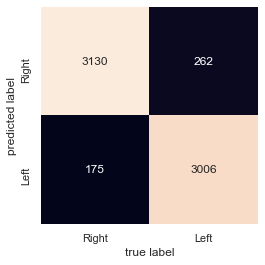

In [468]:
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()


mat = confusion_matrix(y_test_lem, rf_test_preds)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Right', 'Left'], yticklabels=['Right', 'Left'])
plt.xlabel('true label')
plt.ylabel('predicted label');

# Random Forest with Profanity

In [469]:
rfc_prof = RandomForestClassifier(n_estimators=100,random_state=0,n_jobs=-1,verbose=1)
rfc_prof.fit(prof_train, y_train_lem)
rf_test_preds = rfc_prof.predict(prof_test)

rf_prof_acc_score_lem = accuracy_score(y_test_lem, rf_test_preds)
rf_prof_f1_score_lem = f1_score(y_test_lem, rf_test_preds)
print('Random Forest with Lemmatization Features and Profanity')
print("Testing Accuracy: {:.4}".format(rf_prof_acc_score_lem))
print()
print("F1 Score: {:.4}".format(rf_prof_f1_score_lem))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s


Random Forest with Lemmatization Features and Profanity
Testing Accuracy: 0.9335

F1 Score: 0.9322


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


In [470]:
feature_importance = pd.DataFrame(sorted(list(zip(prof_columns, rfc_prof.feature_importances_)),key=lambda x: x[1], reverse=True),
             columns=['feature','importance'])

In [471]:
feature_importance.head(10)

,feature,importance
0,hoa,0.041700
1,underpaying,0.028132
2,Xprofanity,0.011027
3,bees,0.008421
4,jurist,0.008107
5,street,0.006794
6,biggly,0.005490
7,vu,0.005379
8,amend,0.005196
9,ojelr5pxgdu,0.004517


**It's interesting that we have a lower accuracy with this model, yet our newly added feature ranks as higher importance than pronouns**

# Random Forest with Capitalization

In [472]:
rfc_cap = RandomForestClassifier(n_estimators=100,random_state=0,n_jobs=-1,verbose=1)
rfc_cap.fit(cap_train, y_train_lem)
rf_test_preds = rfc_cap.predict(cap_test)

rf_cap_acc_score_lem = accuracy_score(y_test_lem, rf_test_preds)
rf_cap_f1_score_lem = f1_score(y_test_lem, rf_test_preds)
print('Random Forest with Lemmatization Features and Capitalization')
print("Testing Accuracy: {:.4}".format(rf_cap_acc_score_lem))
print()
print("F1 Score: {:.4}".format(rf_cap_f1_score_lem))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s


Random Forest with Lemmatization Features and Capitalization
Testing Accuracy: 0.9367

F1 Score: 0.9355


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


In [473]:
feature_importance = pd.DataFrame(sorted(list(zip(cap_columns, rfc_cap.feature_importances_)),key=lambda x: x[1], reverse=True),
             columns=['feature','importance'])

In [474]:
feature_importance.head(10)

,feature,importance
0,hoa,0.044085
1,underpaying,0.027164
2,bees,0.008479
3,jurist,0.008161
4,street,0.007162
5,Xcapitals,0.006070
6,biggly,0.005689
7,vu,0.005575
8,amend,0.005305
9,ojelr5pxgdu,0.004661


# Random Forest with all 3 Features

In [475]:
rfc_combined = RandomForestClassifier(n_estimators=100,random_state=0,n_jobs=-1,verbose=1)
rfc_combined.fit(combined_train, y_train_lem)
rf_test_preds = rfc_combined.predict(combined_test)

rf_combined_acc_score_lem = accuracy_score(y_test_lem, rf_test_preds)
rf_combined_f1_score_lem = f1_score(y_test_lem, rf_test_preds)
print('Random Forest with Lemmatization Features and Capitalization')
print("Testing Accuracy: {:.4}".format(rf_combined_acc_score_lem))
print()
print("F1 Score: {:.4}".format(rf_combined_f1_score_lem))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s


Random Forest with Lemmatization Features and Capitalization
Testing Accuracy: 0.9356

F1 Score: 0.9344


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


In [476]:
feature_importance = pd.DataFrame(sorted(list(zip(combined_columns, rfc_combined.feature_importances_)),key=lambda x: x[1], reverse=True),
             columns=['feature','importance'])

In [478]:
feature_importance.head(50)

,feature,importance
0,hoa,0.045395
1,underpaying,0.028783
2,bees,0.009556
3,jurist,0.008504
4,street,0.007107
5,biggly,0.005330
6,vu,0.005241
7,amend,0.004831
8,catastrophic,0.004791
9,ojelr5pxgdu,0.004788


# SVM

In [395]:
from sklearn.svm import SVC

In [397]:
svc_lemma = SVC(verbose=1)
svc_lemma.fit(tfidf_data_train_lem, y_train_lem)
rf_test_preds = svc_lemma.predict(tfidf_data_test_lem)

rf_acc_score_lem = accuracy_score(y_test_lem, rf_test_preds)
rf_f1_score_lem = f1_score(y_test_lem, rf_test_preds)
print('Random Forest with Lemmatization Features')
print("Testing Accuracy: {:.4}".format(rf_acc_score_lem))
print()
print("F1 Score: {:.4}".format(rf_f1_score_lem))

[LibSVM]Random Forest with Lemmatization Features
Testing Accuracy: 0.9356

F1 Score: 0.9339


## MN Naive Bayes

In [375]:
mnb_lemma = MultinomialNB()
mnb_lemma.fit(tfidf_data_train_lem, y_train_lem)
mnb_test_preds = mnb_lemma.predict(tfidf_data_test_lem)

mnb_acc_score_lem = accuracy_score(y_test_lem, mnb_test_preds)
mnb_f1_score_lem = f1_score(y_test_lem, mnb_test_preds)
print('Multinomial Naive Bayes model accuracy')
print("Testing Accuracy: {:.4}".format(mnb_acc_score_lem))
print()
print("F1 Score: {:.4}".format(mnb_f1_score_lem))

Multinomial Naive Bayes model accuracy
Testing Accuracy: 0.8801

F1 Score: 0.8789


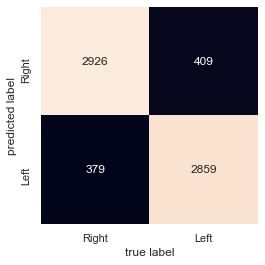

In [376]:
mat = confusion_matrix(y_test_lem, mnb_test_preds)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Right', 'Left'], yticklabels=['Right', 'Left'])
plt.xlabel('true label')
plt.ylabel('predicted label');

In [377]:
y_test_lem.index

Int64Index([13945,  6183,  7323,  8678,  9725,   142,  8214, 10630, 13450,
             5728,
            ...
            17422,  5401,  8138, 14548, 12747, 16922, 17135,  1454,  1501,
             9295],
           dtype='int64', length=6573)

In [378]:
test = comments_df.loc[y_test_lem.index]
test['pred'] = rf_test_preds
test['pred'] = test['pred'].apply(lambda x: 'right' if x == 1 else 'left')

KeyError: 'Passing list-likes to .loc or [] with any missing labels is no longer supported, see https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike'

In [379]:
guessed_right_wrong = test[(test.comment_class != test.pred) & (test.pred == 'right')]
guessed_right_wrong.reset_index(drop=True, inplace=True)

guessed_left_wrong = test[(test.comment_class != test.pred) & (test.pred == 'left')]
guessed_left_wrong.reset_index(drop=True, inplace=True)


NameError: name 'test' is not defined

In [380]:
print("GUESSED RIGHT BUT WE WERE WRONG")
print("_______________________________")
for i in range(0,50):
    print(guessed_right_wrong.iloc[i].body)
    print('----------')

GUESSED RIGHT BUT WE WERE WRONG
_______________________________


NameError: name 'guessed_right_wrong' is not defined

In [381]:
print("GUESSED LEFT BUT WE WERE WRONG")
print("______________________________")
for i in range(0,50):
    print(guessed_left_wrong.iloc[i].body)
    print('----------')

GUESSED LEFT BUT WE WERE WRONG
______________________________


NameError: name 'guessed_left_wrong' is not defined